In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from IPython.display import clear_output

EPOCHS = 5
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [3]:
from models import ResNet18, ResNet34, EnsembleModel

In [4]:
from training_functions import plot_history, train, test, train_epoch

In [5]:
df = pd.read_csv('annotations/trainval.txt', sep=' ', names=['IMGNAME', 'CLASSID', 'SPECIE', 'ID'])
df['ID'] -= 1
df = df[df['SPECIE'] == 1]
df = df[['IMGNAME', 'ID']]
# print(df)

test_df = pd.read_csv('annotations/test.txt', sep=' ', names=['IMGNAME', 'CLASSID', 'SPECIE', 'ID'])
test_df['ID'] -= 1
test_df = test_df[test_df['SPECIE'] == 1]
test_df = test_df[['IMGNAME', 'ID']]

df = pd.concat([df, test_df], axis=0)

BALANCED_SIZE = len(df) * 0.8

In [6]:
train_df, valtest_df = train_test_split(df, test_size=0.2, random_state=42)

val_df, test_df = train_test_split(valtest_df, test_size=0.33, random_state=42)

# 3. Датасет PyTorch
class ImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0]) + '.jpg'
        # print(img_name)
        image = Image.open(img_name).convert('RGB')
        label = int(self.df.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 4. Трансформации изображений
transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [7]:
# 5. Создание DataLoader
train_dataset = ImageDataset(train_df, root_dir='images', transform=transform)
val_dataset = ImageDataset(val_df, root_dir='images', transform=transform)
test_dataset = ImageDataset(test_df, root_dir='images', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
num_classes = 12
modelResNet18 = ResNet18(num_classes, 'ResNet18').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelResNet18.parameters(), lr=0.001)

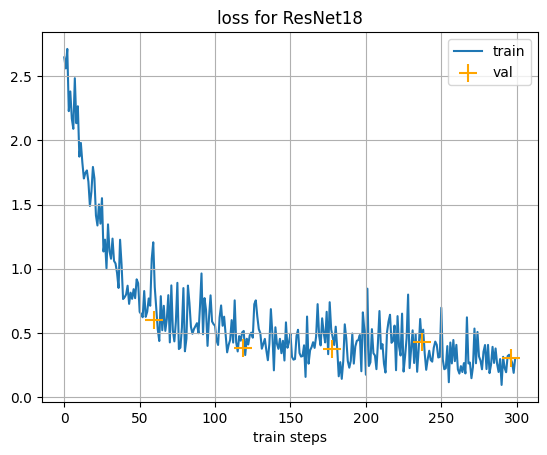

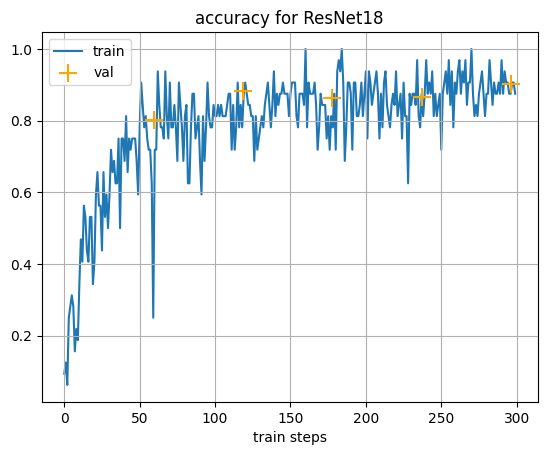

Loss: 0.30841913968324663
Acc: 0.9025000000000001
Best model saved


In [9]:
train(modelResNet18, optimizer, criterion, EPOCHS, train_loader, val_loader, 'cats_breed18.pth', BALANCED_SIZE, BATCH_SIZE)

In [10]:
modelResNet18.load_state_dict(torch.load('cats_breed18.pth', weights_only=True))

<All keys matched successfully>

In [11]:
modelResNet34 = ResNet34(num_classes, 'ResNet34').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelResNet34.parameters(), lr=0.001)

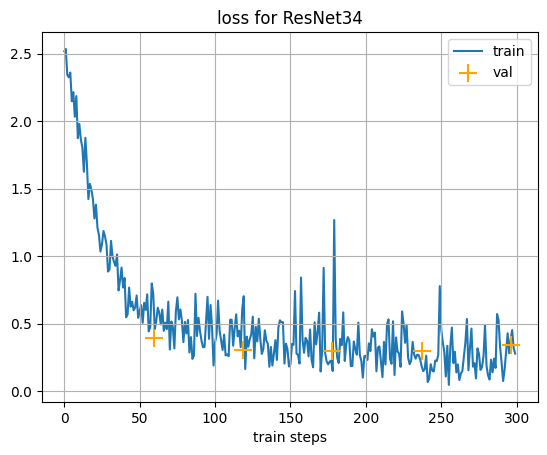

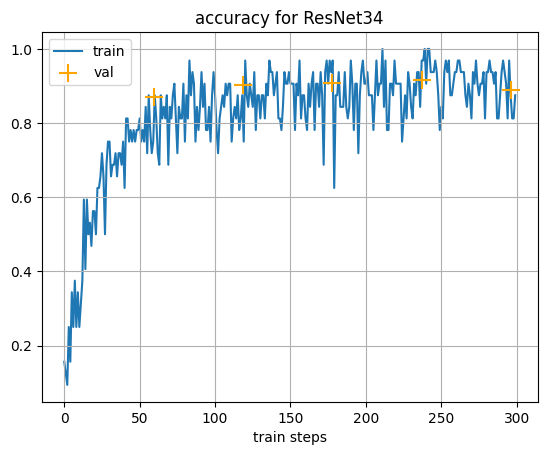

Loss: 0.3392717808485031
Acc: 0.8895833333333334


In [12]:
train(modelResNet34, optimizer, criterion, EPOCHS, train_loader, val_loader, 'cats_breed34.pth', BALANCED_SIZE, BATCH_SIZE)

In [13]:
modelResNet34.load_state_dict(torch.load('cats_breed34.pth', weights_only=True))

<All keys matched successfully>

In [14]:
cat_breed_ensemble = EnsembleModel([modelResNet18, modelResNet34])

In [15]:
loss1, acc1 = test(modelResNet34, criterion, test_loader)
clear_output()
loss2, acc2 = test(modelResNet18, criterion, test_loader)
clear_output()
loss3, acc3 = test(cat_breed_ensemble, criterion, test_loader)
clear_output()

In [16]:
print(f"ResNet34\nLoss: {np.mean(loss1)}\nAcc: {np.mean(acc1)}\n")
print(f"ResNet18\nLoss: {np.mean(loss2)}\nAcc: {np.mean(acc2)}\n")
print(f"Ensemble\nLoss: {np.mean(loss3)}\nAcc: {np.mean(acc3)}\n")

ResNet34
Loss: 0.34042122960090637
Acc: 0.9036637931034482

ResNet18
Loss: 0.2939189910888672
Acc: 0.8842672413793103

Ensemble
Loss: 0.2583454579114914
Acc: 0.8905172413793103

